# 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Bagging"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 배깅: 부트스트랩 샘플리을 통한 분류 앙상블

다양한 분류기를 만드는 한 가지 방법은 각기 다른 훈련 알고리즘을 사용하는 것이다. 또 다른 방법은 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것이다. 훈련 세트에서 중복을 허용하여 샘플링하는 방식을 <b>배깅</b><sup>bagging</sup>(bootstrap aggregating의 줄임말<sup><a id="a02" href="#p01">[1]</a></sup>)이라 하며, 중복을 허용하지 않고 샘플링하는 방식을 <b>페이스팅</b><sup>pasting</sup>이라고 한다.

다시 말해 배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용할 수 있다. 하지만 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링할 수 있다. 교차 검증이 데이터 세트 간에 중첩을 허용하지 않는 것과 다르게 배깅 방식은 중첩을 허용한다. 따라서 10,000개의 데이터를 10개의 분류기가 배깅 방식으로 나누더라도 각 1,000개의 데이터 내에는 중복된 데이터가 있다. 이 샘플링과 훈련 과정을 [그림 1]에 타나냈다.

<b>그림 1</b> 배깅과 페이스팅은 훈련 세트에서 무작위로 샘플링하여 여러 개의 예측기를 훈련한다.
<div style="text-align:center;">
    <img src="./images/Bagging/bagging.png">
</div>

## 배깅 알고리즘의 작동 방식

배깅 분류기의 부트스트랩 샘플링의 작동 방식을 확실히 이해하기 위해 [그림 2]에 나오는 예를 생각해 보자. 다음에 (1에서 7까지 인덱스가 부여된) 일곱 개의 훈련 샘플이 있다. 배깅 단계마다 중복을 허용하여 랜덤하게 샘플링된다. 각각의 부트스트랩 샘플을 사용하여 분류기 $C_j$를 학습한다. 일반적으로 가지치기하지 않는 결정 트리를 분류기로 사용한다.

<b>그림 2</b> 배깅과 페이스팅은 훈련 세트에서 무작위로 샘플링하여 여러 개의 예측기를 훈련한다.
<div style="text-align:center;">
    <img src="./images/Bagging/bootstrap.png">
</div>

[그림 2]에서 볼 수 있듯이 각 분류기는 훈련 세트에서 추출한 랜덤한 부분 집합을 사용한다. 중복을 허용한 샘플링을 하기 때문에 각 부분 집합에는 일부가 중복되어 있고 원본 샘플 중 일부는 포함되어 있지 않다. 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다. 수집 함수는 전형적으로 분류일 때는 <b>통계적 최빈값</b><sup>statistical mode</sup>(즉, 직접 투표 분류기처럼 가장 많은 예측 결과)이고 회귀에 대해서는 평균을 계산한다. 개별 예측기는 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소한다. 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어든다.

[그림1]에서 볼 수 있듯이 예측기는 모두 동시에 다른 CPU 코어나 서버에서 병렬로 학습시킬 수 있다. 이와 유사하게 예측도 병렬로 수행할 수 있다. 이런 확장성 덕분에 배깅과 페이스팅의 인기가 높다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> 1994년 레오 브레이만<sup>Leo Breiman</sup>이 기술 보고서에서 배깅을 처음 제안했다. 배깅으로 불안정한 모델의 정확도를 향상하고 과대적합의 정도를 감소시킬 수 있다는 것을 보였다. 배깅에 관해 더 자세히 알고 싶다면 온라인에 공개된 그의 리포트를 꼭 한 번 읽어 보자.<sup><a id="a02" href="#p02">[2]</a></sup>
</div>

## 사이킷런의 배깅과 페이스팅

사이킷런은 배깅과 페이스팅을 위해 간편한 API로 구현된 BaggingClassifier(회귀의 경우에는 BaggingRegressor)를 제공한다. 다음은 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드다.<sup><a id="a03" href="#p03">[3]</a></sup> 각 분류기는 훈련 세트에 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련된다(이는 배깅의 경우이고, 대신 페이스팅을 사용하려면 bootstrap=False로 지정하면 된다). n_jobs 매개변수는 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정한다(-1로 지정하면 가용한 모든 코어를 사용한다).

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = make_moons(n_samples=500 ,noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [4]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print("Bagging의 정확도: %.2f" % accuracy_score(y_test, y_pred))
print("Decision Tree의 정확도: %.2f" % accuracy_score(y_test, y_pred_tree))

Bagging의 정확도: 0.90
Decision Tree의 정확도: 0.86


<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> BaggingClassifier는 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면(즉, predict_proba() 함수가 있으면) 직접 투표 대신 자동으로 간접 투표 방식을 사용한다.
</div>

다음 그림은 단일 결정 트리의 결정 경계와 500개의 트리를 사용한 배깅 앙상블(이전 코드로 만든 모델)의 결정 경계를 비교한 것이다. 둘 다 moons 데이터셋에 훈련시켰다. 여기서 볼 수 있듯이 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘된 것 같다. 앙상블은 비슷한 편향에서 더 작은 분산을 만든다(훈련 세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙하다).

In [5]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

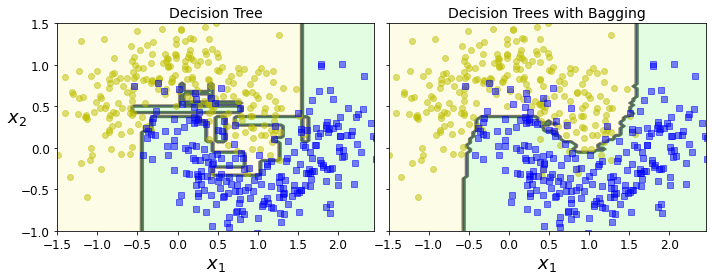

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

실전에서 고차원 데이터셋을 사용하는 더 복잡한 분류 문제라면 단일 결정 트리가 쉽게 과대적합될 수 있다. 이런 경우에 배깅 알고리즘의 강력함이 제대로 발휘될 수 있다. 마지막으로 배깅 알고리즘은 모델의 분산을 감소하는 효과적인 방법이지만 모델의 편향을 낮추는 데는 효과적이지 않다. 즉, 모델이 너무 단순해서 데이터에 있는 경향을 잘 잡아내지 못한다. 이것이 배깅을 수행할 때 편향이 낮은 모델, 예를 들어 가지치기하지 않은 결정 트리를 분류기로 사용하여 앙상블을 만드는 이유다.

부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높다. 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킨다. 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호한다. 그러나 시간과 CPU 파워에 여유가 있다면 교차 검증으로 배깅과 페이스팅을 모두 평가해서 더 나은 쪽을 선택하는 것이 좋다.

## oob 평가

배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있다. BaggingClassifier는 기본값으로 중복을 허용하여(bootstrap=True) 훈련 세트의 크기만큼만인 n개 샘플을 선택한다. 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미한다. 선택되지 않은 훈련 샘플의 나머지 37%를 oob<sup>out-of-bag</sup> 샘플이라고 부른다. 예측기마다 남겨진 37%는 모두 다르다.

예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있다. 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻는다.

사이킷런에서 BaggingClassifier를 만들 때 oob_score=True로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행한다. 다음 코드는 이 과정을 보여준다. 평가 점수 결과는 oob_score_ 변수에 저장되어 있다.

In [12]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

oob 평가 결과를 보면 이 BaggingClassifier는 테스트 세트에서 약 89.9%의 정확도를 얻을 것으로 보인다. 확인해보자.

In [11]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

테스트 세트에서 91.2%의 정확도를 얻었다. 얼추 비슷하다.

oob 샘플에 대한 결정 함수의 값도 oob_decision_function_ 변수에서 확인할 수 있다. 이 경우 결정 함수는 각 훈련 샘플의 클래스 확률을 반환한다(기반이 되는 예측기가 <code>predict_proba()</code> 메서드를 갖고 있기 때문에). 다음 예를 보면 oob 평가는 첫 번째 훈련 샘플이 양성 클래스에 속할 확률을 67.72%로 추정하고 있다(그리고 음성 클래스에 속할 확률은 32.28%다).

In [15]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

# 미주

<b id="p01">1</b> 통계학에서는 중복을 허용한 리샘플링<sup>resampling</sup>을 <b>부트스트래핑</b><sup>bootstrapping</sup>이라고 한다. [↩](#a01)

<b id="p02">2</b> <a href="https://link.springer.com/content/pdf/10.1007/BF00058655.pdf" target='blank'>Bagging predictors, L. Breiman, Machine Learning, 24(2): 123-140, 1996</a> [↩](#a02)

<b id="p03">3</b> max_samples 매개변수는 0.0 ~ 1.0 사이의 실수로 지정할 수도 있다. 이렇게 지정하면 샘플리오디는 데이터 수는 훈련 세트의 크기에 max_samples를 곱한 값이 된다. [↩](#a03)

<b id="p04">4</b> n이 커지면 이 비율이 $1 - \mathrm{exp}(-1)\approx63.212$%에 가까워진다. n개의 샘플에서 무작위로 하나를 추출할 때 선택되지 않을 확률은 $1 - \frac{1}{n}$이고 이를 n번 반복했을 때도 선택되지 않을 확률은 $(1-\frac{1}{n})^n$이다. 여기에 로그를 취하고 로피탈의 정리를 적용하면 이 값이 $e^{-1}$과 같아진다. 따라서 샘플링될 확률은 $1-e^{-1} = 0.63212$가 된다. [↩](#a04)